## Training ML models


Once you have explored the repository and selected an appropriate training dataset, you can stage it and train a model. In this notebook we will show an example of how to do so using the [Deep Globe Road Extraction](https://www.eotdl.com/datasets/DeepGlobeRoadExtraction) dataset.

> Remember that you can run this notebook in your cloud workspace to train a model in the cloud. If you require a GPU-powered machine, let us know though Discord and we will provide one!


In order to streamline the training process, we will use the [PytorchEO](https://github.com/earthpulse/pytorchEO) library. This open source library is built on top of [Pytorch](https://pytorch.org/) and [Pytorch Lightning](https://lightning.ai/) to facilitate the design, implementation, training and deployment of deep learning models for Earth Observation. It offers AI-Ready EO datasets as well as ready-to-use tasks and models.


In [3]:
from pytorch_eo.datasets import DeepGlobeRoadExtraction

ds = DeepGlobeRoadExtraction(batch_size=5)

ds.setup()

Staging assets: 100%|██████████| 1/1 [06:42<00:00, 402.94s/it]


It is not our goal to provide a complete tutorial on how to train a model, but rather to show how to use the EOTDL. If you want to learn more about AI and training deep neural networks, we encourage you to explore the [PytorchEO](https://github.com/earthpulse/pytorchEO) library, and even contribute with more datasets, tasks, models and wrappers. We challenge you to train a better model!


> This might take a few minutes!


In [4]:
ds.df

image  \
0     data/DeepGlobeRoadExtraction/train/100034_sat.jpg   
1     data/DeepGlobeRoadExtraction/train/100081_sat.jpg   
2     data/DeepGlobeRoadExtraction/train/100129_sat.jpg   
3     data/DeepGlobeRoadExtraction/train/100703_sat.jpg   
4     data/DeepGlobeRoadExtraction/train/100712_sat.jpg   
...                                                 ...   
6221  data/DeepGlobeRoadExtraction/train/999431_sat.jpg   
6222  data/DeepGlobeRoadExtraction/train/999531_sat.jpg   
6223  data/DeepGlobeRoadExtraction/train/999667_sat.jpg   
6224  data/DeepGlobeRoadExtraction/train/999764_sat.jpg   
6225   data/DeepGlobeRoadExtraction/train/99995_sat.jpg   

                                                   mask  
0     data/DeepGlobeRoadExtraction/train/100034_mask...  
1     data/DeepGlobeRoadExtraction/train/100081_mask...  
2     data/DeepGlobeRoadExtraction/train/100129_mask...  
3     data/DeepGlobeRoadExtraction/train/100703_mask...  
4     data/DeepGlobeRoadExtraction/train/100712_mask...  
...                                                 ...  
6221  data/DeepGlobeRoadExtraction/train/999431_mask...  
6222  data/DeepGlobeRoadExtraction/train/999531_mask...  
6223  data/DeepGlobeRoadExtraction/train/999667_mask...  
6224  data/DeepGlobeRoadExtraction/train/999764_mask...  
6225  data/DeepGlobeRoadExtraction/train/99995_mask.png  

[6226 rows x 2 columns]

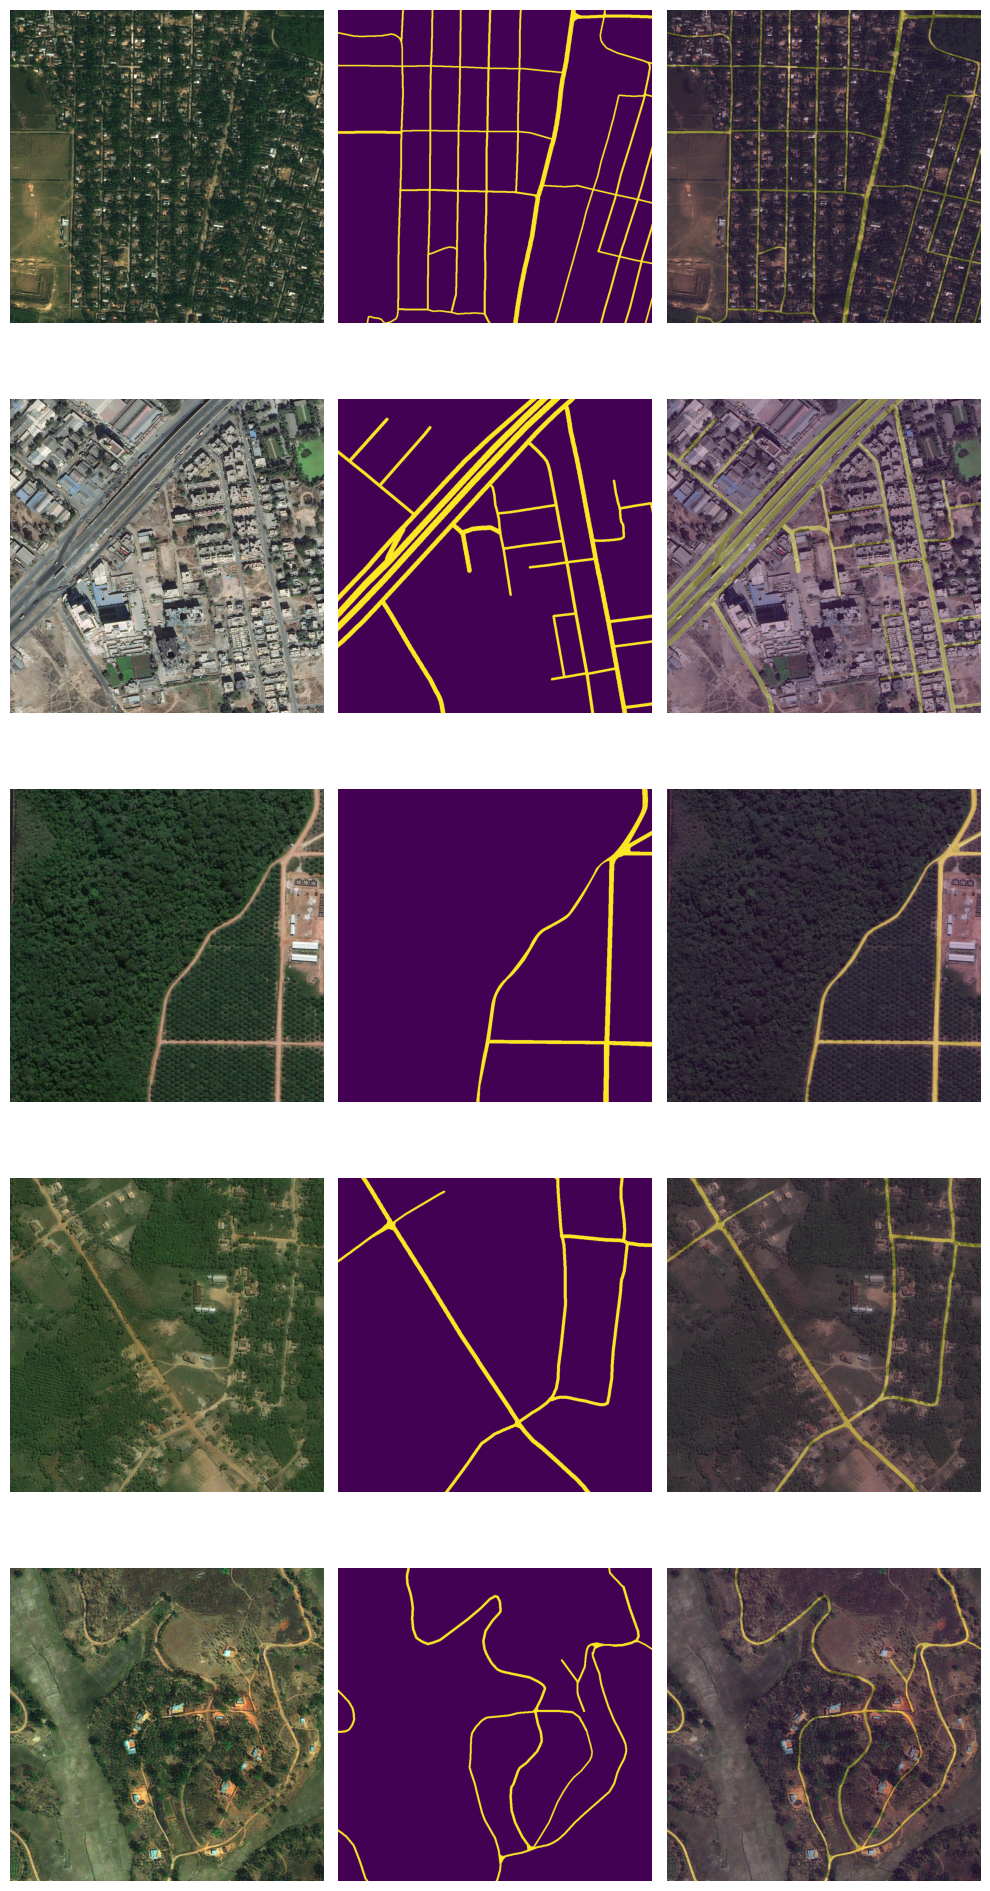

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange

batch = next(iter(ds.train_dataloader()))
imgs, masks = batch["image"], batch["mask"]

imgs = rearrange(imgs, "b c h w -> b h w c")
masks = masks.squeeze(1)

fig = plt.figure(figsize=(10, len(imgs) * 4))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    ax = plt.subplot(len(imgs), 3, 3 * i + 1)
    ax.imshow(img)
    ax.axis("off")
    ax = plt.subplot(len(imgs), 3, 3 * i + 2)
    ax.imshow(mask)
    ax.axis("off")
    ax = plt.subplot(len(imgs), 3, 3 * i + 3)
    ax.imshow(img)
    ax.imshow(mask, alpha=0.3)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Training


Let's train a U-Net model with default parameters. You can see an advanced example in [road_segmentation.py](https://github.com/earthpulse/pytorchEO/blob/main/examples/road_segmentation.py).


In [6]:
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_eo.tasks import ImageSegmentation

ds_trainer = DeepGlobeRoadExtraction(batch_size=8, num_workers=20, pin_memory=True)

task = ImageSegmentation(num_classes=ds_trainer.num_classes)

trainer = L.Trainer(
    # accelerator="cuda",   # descomentar para usar GPU
    accelerator="cpu",
    devices=1,
    max_epochs=10,
    limit_train_batches=10,  # comment this line to train on the full dataset
    limit_val_batches=10,  # comment this line to validate on the full dataset
    callbacks=[
        ModelCheckpoint(
            monitor="val_iou",
            mode="max",
            save_top_k=1,
            dirpath="checkpoints",
            filename="unet-{epoch:02d}-{val_iou:.2f}",
        )
    ],
)

# uncomment the following line to train the model
# trainer.fit(task, ds_trainer)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/fran/Documents/dev/workshop-eotdl-bids2025/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/fran/Documents/dev/workshop-eotdl-bids2025/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


## Evaluate


Once the model is trained you can evaluate it using some test data.


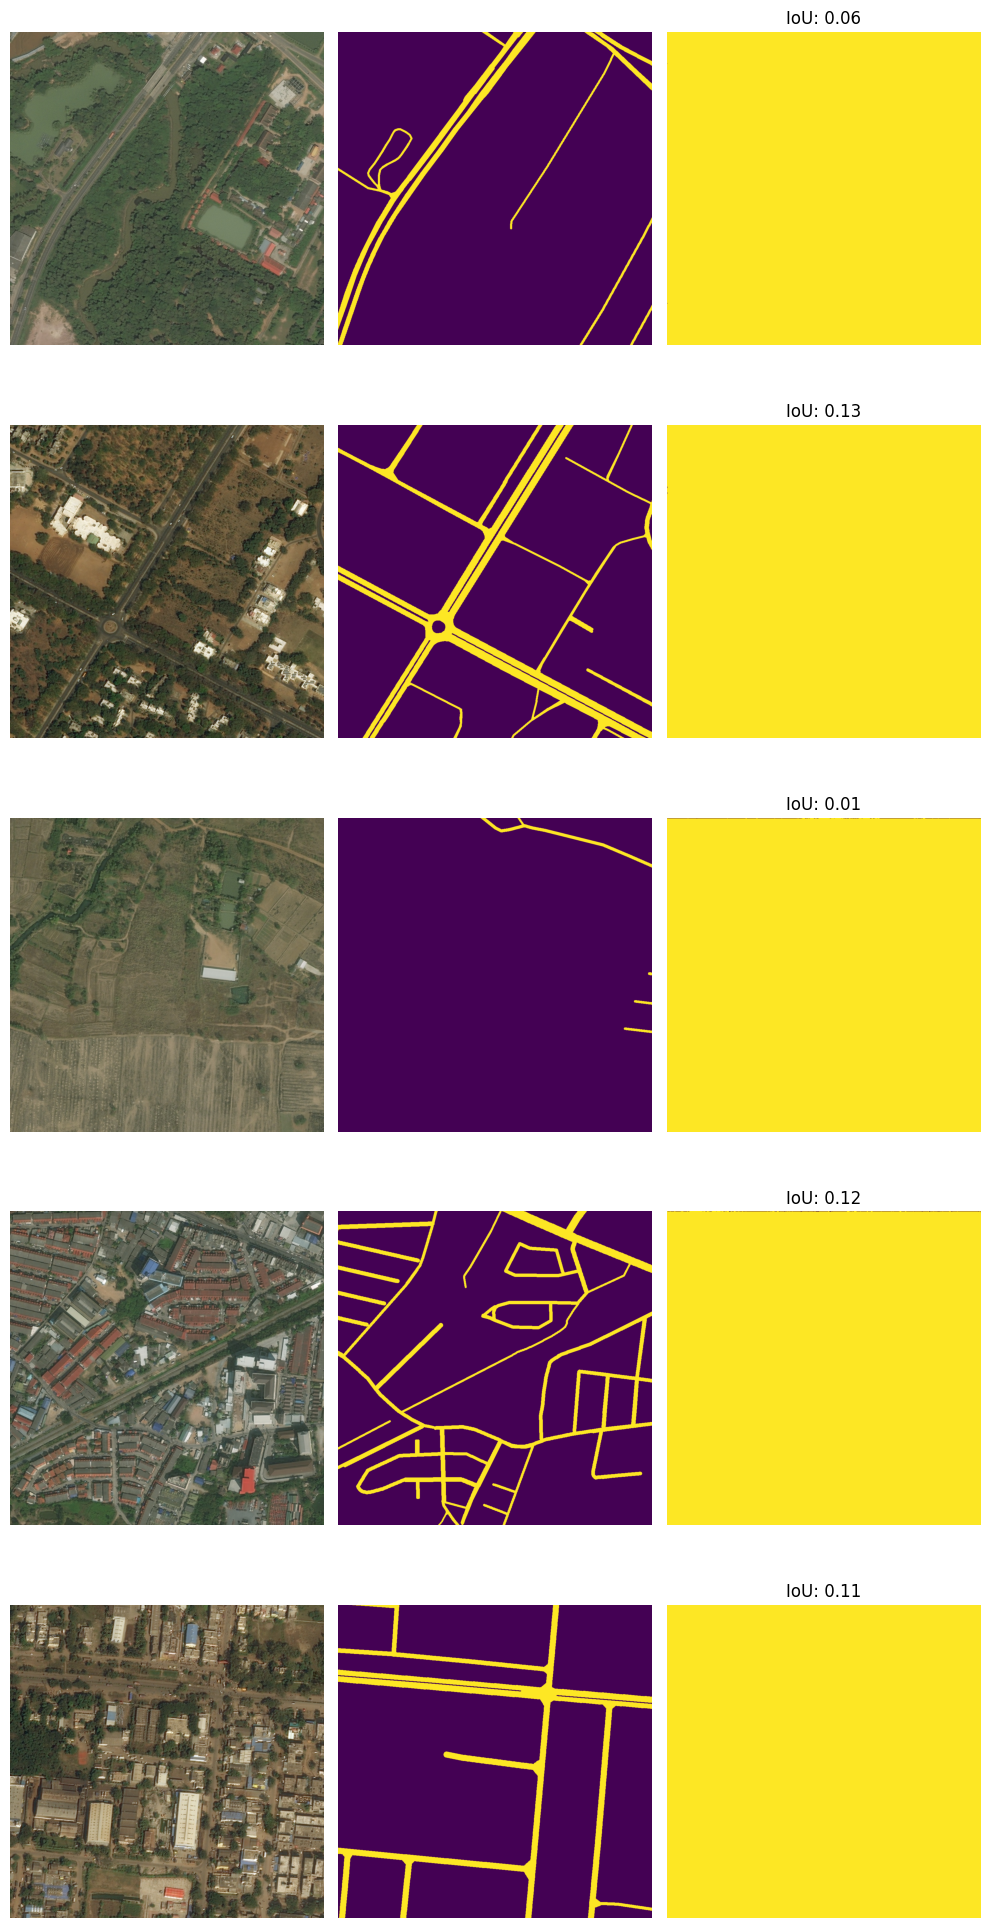

In [7]:
import matplotlib.pyplot as plt
import torch
from einops import rearrange
from pytorch_eo.metrics.segmentation import iou

# ds = DeepGlobeRoadExtraction(batch_size=5)
# ds.setup()

batch = next(iter(ds.val_dataloader()))
imgs, masks = batch["image"], batch["mask"]

task.cpu()
preds = task.predict(batch) > 0.5

imgs = rearrange(imgs, "b c h w -> b h w c")
masks = masks.squeeze(1)
preds = preds.squeeze(1)

fig = plt.figure(figsize=(10, len(imgs) * 4))
for i, (img, mask, pred) in enumerate(zip(imgs, masks, preds)):
    ax = plt.subplot(len(imgs), 3, 3 * i + 1)
    ax.imshow(img)
    ax.axis("off")
    ax = plt.subplot(len(imgs), 3, 3 * i + 2)
    ax.imshow(mask)
    ax.axis("off")
    ax = plt.subplot(len(imgs), 3, 3 * i + 3)
    ax.imshow(pred)
    _iou = iou(pred.unsqueeze(0), mask.unsqueeze(0))
    ax.set_title(f"IoU: {_iou:.2f}")
    ax.axis("off")
plt.tight_layout()
plt.show()

## Export the model


And export it to later ingestion to the EOTDL. You can choose your preferred export method, here we use [ONNX]().


In [ ]:
# !uv add onnx onnxruntime

In [9]:
filepath = "data/road-segmentation-bids2025/model.onnx"

!mkdir -p data/road-segmentation-bids2025

batch = next(iter(ds.val_dataloader()))
imgs, masks = batch["image"], batch["mask"]

task.cpu()
task.eval()

task.to_onnx(
    filepath,
    imgs,
    export_params=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size", 2: "height", 3: "width"},
        "output": {0: "batch_size"},
    },
)

This has been a fast and easy example on how to train an ML model with a datasets downloaded from EOTDL. Este bloque de código realiza **inferencia** utilizando el modelo en formato **ONNX** y el conjunto de imágenes como entrada.


In [10]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession(filepath)
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: imgs.numpy()}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

(5, 1, 1024, 1024)

You will learn how to ingest this model to EOTDL in following notebooks!


## Discussion and Contribution opportunities


Feel free to ask questions now (live or through Discord) and make suggestions for future improvements.

- What would you like to see in the EOTDL concerning training?
- What are the main challenges you face when training ML models with EO data?
- What are the main datasets you would like to see in the EOTDL?
- What are the main tasks you would like to see implemented?
- What are the main models you would like to see implemented?
- What are the frameworks you would like to have wrappers for?
